# CLASSIFICATION PRACTICAL EXAM

# South Africa Language Identification Hack23

## 1.0 Introduction

Language identification can be an interesting and challenging problem, especially in multilingual regions like South Africa where multiple languages are spoken. 

This project aims to develop a language identification model for classifying text into one of South Africa's 11 official languages. The project utilizes natural language processing techniques to identify the language of a given piece of text. By accurately identifying the language, this model can contribute to various applications, such as multilingual communication systems and language-based analysis.

Overall, this language identification project contributes to the broader goal of promoting language diversity, understanding, and effective communication in South Africa's multicultural society. By accurately identifying languages, we can pave the way for more inclusive and culturally aware digital environments.
___

## 1.1 Importing the Necessary Libraries

To begin, we need to import the required libraries and packages for data manipulation, preprocessing, modeling, and evaluation. These libraries include popular NLP libraries sklearn, as well as other utility libraries.


In [46]:
#Import the libraries 
import numpy as np                                              #For statistics, array creation and manipulation
import pandas as pd                                             #For data loading and data manipulation
import seaborn as sns                                           #For data visualization
from wordcloud import WordCloud                                 #For visualizing the summarized textual data
import matplotlib.pyplot as plt                                 #For data visualization - %matplotlib below is a magic command to render matplotlib in jupyter
%matplotlib inline 
import re                                                       #For data cleaning to remove/replace unwanted patterns
import string                                                   #For data cleaning to remove/replace unwanted patterns
from sklearn.feature_extraction.text import TfidfVectorizer       #For mapping/converting words into real numbers
from sklearn.feature_extraction.text import CountVectorizer       #For mapping/converting words into real numbers
from sklearn.preprocessing import LabelEncoder                    #For converting words into real numbers
from sklearn.model_selection import train_test_split              #For splitting the dataset into train and test
from sklearn.preprocessing import MaxAbsScaler                    #For scaling our data
from sklearn.metrics import classification_report, accuracy_score #For evaluating model preformance
from sklearn.model_selection import GridSearchCV                  #For hyperparameter tuning
from sklearn.linear_model import LogisticRegression               #For building a logistic regression model
from sklearn.ensemble import RandomForestClassifier               #For building a random forest model
from sklearn.svm import SVC                                       #For building a support vector classifier model
from sklearn.naive_bayes import MultinomialNB                     #For building a Naive Bayes multinomial model


from nltk.corpus import stopwords                                 #For stopwords processing
from nltk.tokenize import word_tokenize, TreebankWordTokenizer    #For splitting sentences into words


## 1.2 Loaing the Data

We will start by loading the training and test datasets into pandas DataFrames for further analysis and modeling. The training dataset contains labeled text samples for language identification, while the test dataset will be used for final evaluation.

In [2]:
#Load the data
df_train = pd.read_csv("train_set.csv")
df_test = pd.read_csv("test_set.csv")

In [3]:
df_train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [4]:
df_test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


#### The train data contains 2 columns - lang_id and text with the lang_id being the response variable.
#### The test data contains 2 columns as well - Index and text. The lang_id is to be predicted.
___

# 2.0 Exploratory Data Analysis

Before building our language identification model, it is essential to explore and understand the dataset. This includes analyzing the distribution of languages, identifying any data quality issues, and gaining insights into the text samples.

In [5]:
# Columns of the train data
df_train.columns

Index(['lang_id', 'text'], dtype='object')

In [6]:
# Columns of the test data
df_test.columns

Index(['index', 'text'], dtype='object')

In [7]:
# Shape of the train data
df_train.shape

(33000, 2)

In [8]:
# Shape of the test data
df_test.shape

(5682, 2)

In [16]:
# Lets check for null values 

df_train.isna().sum()

lang_id    0
text       0
dtype: int64

In [9]:
# Count the number of unique languages 
df_train['lang_id'].nunique()

11

In [10]:
# Count the occurrences of each language using the language ID
df_train['lang_id'].value_counts()

lang_id
xho    3000
eng    3000
nso    3000
ven    3000
tsn    3000
nbl    3000
zul    3000
ssw    3000
tso    3000
sot    3000
afr    3000
Name: count, dtype: int64

In [11]:
# Display the unique columns

unique_ids = [ids for ids in df_train['lang_id'].unique()] #loops through the lang_id colun and returns only unique ids
unique_ids

['xho', 'eng', 'nso', 'ven', 'tsn', 'nbl', 'zul', 'ssw', 'tso', 'sot', 'afr']

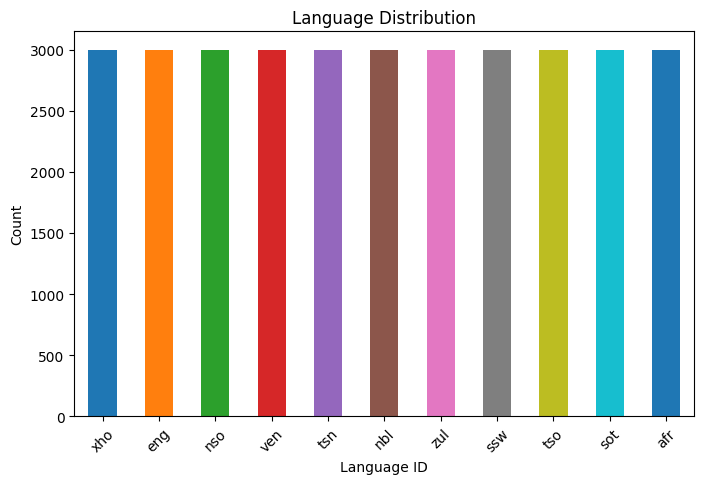

In [12]:
# Display the language distribution using matplotlib

# Count the occurrences of each language ID
lang_counts = df_train['lang_id'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 5))
lang_counts.plot(kind='bar', color = sns.color_palette())

# Define the custom labels and figure size
lang_labels = {lang_id: lang_id for lang_id in unique_ids}

# Customize xticks and rotation of x-axis labels to improve readability
plt.xticks(range(len(lang_counts.index)),lang_counts.rename(index=lang_labels).index, rotation=45)

plt.title('Language Distribution')
plt.xlabel('Language ID')
plt.ylabel('Count')
plt.show()

We have a dataset with 33,000 rows and 2 columns (language ID and text). The dataset appears to be  well-balanced, with an equal distribution of 3,000 samples for each of the 11 language IDs. 

The next step is to carry out the following preprocessing activities
- Data cleaning - remove punctuations, remove special characters
- Normalize the data by converting the text data to lower case
- Tokenizing the data.

We will not carry out stopwords removal just yet, as it is still unsure how this will affect the model. We will experiment with both stopwords and without to see how it affects the model. Experiment shows that with stop words the model performs better.

In [13]:
#Check for duplicates in the data

df_train.duplicated().sum()

3052

#### The data contains 3,052 duplicates this could be the reason the data was uniformly distributed across the various language ids. In the cell below we remove the duplicates. 

In [22]:
# Remove duplicates but keep the first occurence of the text

df = df_train.copy() #Making a copy of the data to avoid modifying the original

df = df.drop_duplicates(keep='first')
df.duplicated().sum()

0

In [18]:
#Checking the shape of our data after removing duplicates
df.shape

(29948, 3)

## 2.1 Data Cleaning

The dataset contains noise - remove ounctuations, non-alphanumeric characters. We need to perform data cleaning to ensure the data is suitable for modeling. This step involves removing unnecessary characters etc.

In [24]:
def clean_text(text):
    
    text = text.lower() # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    text = re.sub(r'([^\s\w“”]|_)+', '', text) # Remove non-alphanumeric characters such as repeated punctuation marks
    text = ' '.join(text.split()) # Remove whitespace

    return text.strip()

df['clean_text'] = df['text'].apply(clean_text)
df.head()

,lang_id,text,clean_text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,umgaqosiseko wenza amalungiselelo kumaziko axh...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,idha iya kuba nobulumko bokubeka umsebenzi nap...
2,eng,the province of kwazulu-natal department of tr...,the province of kwazulunatal department of tra...
3,nso,o netefatša gore o ba file dilo ka moka tše le...,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...


## 2.2 Data Visualizations

This can help us understand the distribution of languages in the dataset and identify any patterns or imbalances. We can create plots such as bar charts or word clouds to visualize the data.

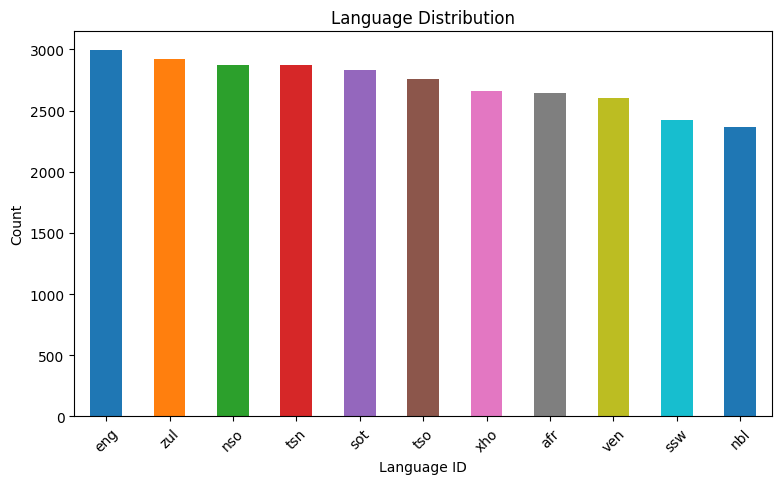

In [19]:
#Lets plot our language distribution again after removing duplicates

# Count the occurrences of each language ID
lang_counts = df['lang_id'].value_counts()

# Plot the distribution
plt.figure(figsize=(9, 5))
lang_counts.plot(kind='bar', color = sns.color_palette())

# Define the custom labels and figure size
lang_labels = {lang_id: lang_id for lang_id in unique_ids}

# Customize xticks and rotation of x-axis labels to improve readability
plt.xticks(range(len(lang_counts.index)),lang_counts.rename(index=lang_labels).index, rotation=45)

plt.title('Language Distribution')
plt.xlabel('Language ID')
plt.ylabel('Count')
plt.show()

After removing duplicates, our data is now slightly skewed.

In [25]:
# Let's calculate the length of the text in each row to help us perform som statictics
df['text_length'] = df['clean_text'].apply(len)
df.head()

,lang_id,text,clean_text,text_length
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,umgaqosiseko wenza amalungiselelo kumaziko axh...,219
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,idha iya kuba nobulumko bokubeka umsebenzi nap...,250
2,eng,the province of kwazulu-natal department of tr...,the province of kwazulunatal department of tra...,263
3,nso,o netefatša gore o ba file dilo ka moka tše le...,o netefatša gore o ba file dilo ka moka tše le...,217
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...,239


In [26]:
# Group by language ID and calculate statistics
lang_stats = df.groupby('lang_id')['text_length'].describe()
lang_stats

,count,mean,std,min,25%,50%,75%,max
lang_id,,,,,,,,
afr,2641.0,245.188944,28.523135,198.0,220.0,244.0,269.0,299.0
eng,2998.0,245.355570,28.489424,196.0,221.0,243.0,270.0,299.0
nbl,2362.0,244.162574,28.317896,192.0,219.0,243.0,267.0,299.0
nso,2873.0,241.705186,28.249518,195.0,217.0,238.0,265.0,299.0
sot,2833.0,246.688316,28.978744,193.0,221.0,245.0,272.0,299.0
ssw,2426.0,244.034213,28.270433,196.0,219.0,241.0,268.0,299.0
tsn,2869.0,245.441617,28.665346,197.0,220.0,244.0,270.0,299.0
tso,2758.0,244.760696,28.387584,196.0,220.0,243.0,269.0,299.0
ven,2605.0,245.426488,28.284171,198.0,221.0,243.0,269.0,299.0


<Figure size 1200x1000 with 0 Axes>

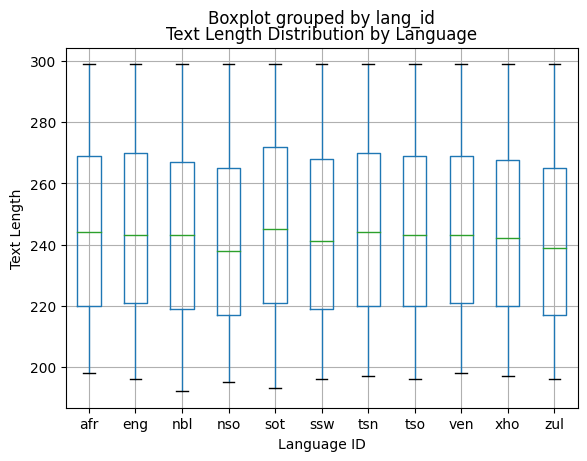

In [29]:
#Let's plot a boxplot, to visualize the distribution of the text length and all look out for outliers

# Plot the text length distribution
plt.figure(figsize=(10, 6))
df.boxplot(column='text_length', by='lang_id')
plt.xlabel('Language ID')
plt.ylabel('Text Length')
plt.title('Text Length Distribution by Language')
plt.show()

Observe that there are no points outside the whiskers, this shows the absence of outliers. When this plot was made with the dataset containing duplicates, some points were observed outside the whiskers. After removing those duplicates, we don't see the outliers anymore and the model performed slightly better.

In [30]:
# Remove columns that are not required 

df = df.drop(['text'], axis =1)

In [31]:
df.head()

,lang_id,clean_text,text_length
0,xho,umgaqosiseko wenza amalungiselelo kumaziko axh...,219
1,xho,idha iya kuba nobulumko bokubeka umsebenzi nap...,250
2,eng,the province of kwazulunatal department of tra...,263
3,nso,o netefatša gore o ba file dilo ka moka tše le...,217
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,239


## 2.3 Preprocessing Test Data

To align the test data with the preprocessing steps applied to the training data, we need to clean it and check for duplicates. This ensures consistency and allows us to make accurate predictions on unseen text samples.

In [32]:
#check for duplicates

df_test.duplicated().sum() 

0

In [36]:
df_test_clean = df_test.copy() #Make a copy to avoid modification of original


def clean_text(text):
    
    text = text.lower() # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuations
    text = re.sub(r'([^\s\w“”]|_)+', '', text) # Remove non-alphanumeric characters such as repeated punctuation marks
    text = ' '.join(text.split()) # Remove whitespace
    
    return text.strip()

df_test_clean['clean_text'] = df_test_clean['text'].apply(clean_text)
df_test_clean.head()

,index,text,clean_text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele...",mmasepala fa maemo a a kgethegileng a letlelel...
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.,tshivhumbeo tshi fana na ngano dza vhathu
3,4,Kube inja nelikati betingevakala kutsi titsini...,kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.,winste op buitelandse valuta


In [37]:
#Lets drop columns that are not required
df_test_clean = df_test_clean.drop(['text'], axis =1)

In [38]:
df_test_clean.head()

,index,clean_text
0,1,mmasepala fa maemo a a kgethegileng a letlelel...
1,2,uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,tshivhumbeo tshi fana na ngano dza vhathu
3,4,kube inja nelikati betingevakala kutsi titsini...
4,5,winste op buitelandse valuta


___

# 3.0 Text Data Transforming

To train a language identification model, we need to convert the text data into numerical representations. This step involves techniques such as tokenization, vectorization (e.g. CountVectorizer, TF-IDF), or label encodings to transform the text data into feature vectors suitable for modeling.


## 3.1 Text Features

First, we will convert the text features into numbers using the count vectorization method. 

In [39]:
#Create an instance to count vectorizer to transform text to real numbers
vectorizer = CountVectorizer(ngram_range=(1,2))

#Fit the text data into vectorizer and transform it
X = vectorizer.fit_transform(df['clean_text'].values.astype(str)) 

## 3.2 Target Variable

Given that our label (ie target variable) is in text format, it is important to convert then to real numbers. We will perform this task using label encoder, since we are dealing with multi-class.

In [40]:
#Create an instance of the label encoder
le = LabelEncoder()

# Fit the lang_id column to the label encoder and transform
y = le.fit_transform(df['lang_id'])

In [41]:
y

array([9, 9, 1, ..., 1, 9, 4])

In [42]:
# Let's Obtain the unique list of label encoder types
labels = list(le.classes_)
labels

['afr', 'eng', 'nbl', 'nso', 'sot', 'ssw', 'tsn', 'tso', 'ven', 'xho', 'zul']

## 3.3 Train-test Data Split

In [43]:
# Split the data into training and testing sets and set a random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
print(X_train.shape)
print(X_test.shape)

(23958, 715943)
(5990, 715943)


___

# 4.0 Model Building and Evaluation

We will now proceed to build our language identification model using the transformed text data. We can choose from various classifiers such as SVC, Naive Bayes, Logistic Regression, or Random Forest. The model will be trained on the training dataset and evaluated using appropriate metrics.

## 4.1 Logistic Regression

Logistic Regression uses a logistic function (sigmoid) to model the probability of an instance belonging to a certain class.

The algorithm learns the best coefficients for the input features to minimize the difference between predicted probabilities and actual class labels. It's simple, interpretable, and commonly used when the relationship between features and the target variable is assumed to be linear.

In [158]:
#Initialize the logistic regression classifier
lr = LogisticRegression(max_iter=1000)

#Train the classifier
lr.fit(X_train, y_train)

#Make Predictions on the testing data
y_pred = lr.predict(X_test)

In [159]:
#Evaluate model performance
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Linear regression Accuracy:", accuracy)
print('Classification Report')
print(classification_report(y_test, y_pred, target_names=labels))

Linear regression Accuracy: 0.993322203672788
Classification Report
              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       553
         eng       1.00      1.00      1.00       603
         nbl       0.98      0.97      0.98       473
         nso       1.00      0.99      1.00       559
         sot       1.00      1.00      1.00       606
         ssw       0.99      0.99      0.99       481
         tsn       1.00      1.00      1.00       543
         tso       1.00      1.00      1.00       548
         ven       1.00      1.00      1.00       509
         xho       0.98      0.99      0.99       503
         zul       0.98      0.98      0.98       612

    accuracy                           0.99      5990
   macro avg       0.99      0.99      0.99      5990
weighted avg       0.99      0.99      0.99      5990



## 4.2 Random Forest Classifier

This is an ensemble learning method that combines multiple decision trees to make predictions. It creates a forest of decision trees, where each tree is trained on a random subset of the data.

During prediction, each tree independently predicts the class, and the final result is determined by majority voting or averaging the predictions. Random Forests are effective for handling complex relationships, feature interactions, and dealing with noisy data.

In [160]:
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the testing data
rf_pred = rf_classifier.predict(X_test)

In [161]:
#Evaluate model performance

# Calculate accuracy
accuracy = accuracy_score(y_test, rf_pred)

print("Random Forest Accuracy:", accuracy)
print('Classification Report')
print(classification_report(y_test, rf_pred, target_names=labels))

Random Forest Accuracy: 0.9849749582637729
Classification Report
              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       553
         eng       0.99      1.00      0.99       603
         nbl       0.98      0.91      0.95       473
         nso       1.00      0.99      1.00       559
         sot       1.00      1.00      1.00       606
         ssw       0.99      0.96      0.98       481
         tsn       0.99      1.00      1.00       543
         tso       1.00      1.00      1.00       548
         ven       1.00      1.00      1.00       509
         xho       0.97      0.98      0.98       503
         zul       0.92      0.97      0.94       612

    accuracy                           0.98      5990
   macro avg       0.99      0.98      0.98      5990
weighted avg       0.99      0.98      0.98      5990



## 4.3 Support Vector Classifier

Support Vector Classifier is a supervised learning algorithm that find the optimal decision boundary that separates the data points of different classes with the largest margin. It finds the best hyperplane in a high-dimensional feature space that maximizes the margin between classes.

In [153]:
#Initialize the SVC model with setting the kernel to linear
svc = SVC(kernel='rbf')

#Train the classifer
svc.fit(X_train, y_train)

#Make predictions on the testing data
svc_pred = svc.predict(X_test)

In [154]:
#Evaluate model performance

# Calculate accuracy
accuracy = accuracy_score(y_test, svc_pred)

print("SVC Accuracy:", accuracy)
print('Classification Report')
print(classification_report(y_test, svc_pred, target_names=labels))

SVC Accuracy: 0.9893155258764608
Classification Report
              precision    recall  f1-score   support

         afr       1.00      0.99      1.00       553
         eng       1.00      1.00      1.00       603
         nbl       0.98      0.95      0.96       473
         nso       1.00      0.99      1.00       559
         sot       1.00      1.00      1.00       606
         ssw       0.99      0.98      0.99       481
         tsn       0.99      1.00      0.99       543
         tso       1.00      1.00      1.00       548
         ven       1.00      1.00      1.00       509
         xho       0.97      0.99      0.98       503
         zul       0.96      0.98      0.97       612

    accuracy                           0.99      5990
   macro avg       0.99      0.99      0.99      5990
weighted avg       0.99      0.99      0.99      5990



## 4.4 Naive Bayes

Naive Bayes is a probabilistic classifier based on Bayes' theorem and assumes independence between features.
It calculates the probability of an instance belonging to a certain class using the conditional probabilities of features given the class. Despite its "naive" assumption, Naive Bayes often performs well and is computationally efficient.

In [51]:
#Initialize the model
nb_classifier = MultinomialNB(alpha = 0.001, fit_prior = True)

# Train the classifier
nb_classifier.fit(X_train, y_train)

# Make predictions on the testing data
nb_pred = nb_classifier.predict(X_test)

In [52]:
#Evaluate model performance

# Calculate accuracy
accuracy = accuracy_score(y_test, nb_pred)

print("Naive Bayes Accuracy:", accuracy)
print('Classification Report')
print(classification_report(y_test, nb_pred, target_names=labels))

Naive Bayes Accuracy: 0.9988313856427379
Classification Report
              precision    recall  f1-score   support

         afr       1.00      1.00      1.00       553
         eng       1.00      1.00      1.00       603
         nbl       1.00      1.00      1.00       473
         nso       1.00      1.00      1.00       559
         sot       1.00      1.00      1.00       606
         ssw       1.00      1.00      1.00       481
         tsn       1.00      1.00      1.00       543
         tso       1.00      1.00      1.00       548
         ven       1.00      1.00      1.00       509
         xho       1.00      1.00      1.00       503
         zul       1.00      0.99      1.00       612

    accuracy                           1.00      5990
   macro avg       1.00      1.00      1.00      5990
weighted avg       1.00      1.00      1.00      5990



### Naive Bayes, showed the best performance so we tuned the parameters using GridSearchCV 

In [47]:
# Define your MultinomialNB classifier
mnb = MultinomialNB()

# Define the parameter grid to search through
param_grid = {
    'alpha': [0.1, 1, 10],
    'fit_prior': [True, False]
}

# Define the grid search with cross-validation
grid_search = GridSearchCV(estimator=mnb, param_grid=param_grid, cv=5, scoring='f1_macro')

# Perform grid search on your data
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'alpha': 0.1, 'fit_prior': True}
Best score: 0.9989721555604912


___

# 5.0 Test Data Prediction

Once our model is trained and evaluated, we can use it to predict the language of the test data. This will allow us to assess the model's performance on unseen text samples and generate predictions for the competition submission.

In [48]:
# Defining the the clean_text
x_test = df_test_clean['clean_text']

In [49]:
# Transforming the test data

x_test = vectorizer.transform(df_test_clean['clean_text'].values.astype(str))

In [53]:
# Predict values using the best model

pred = nb_classifier.predict(x_test)

In [54]:
y

array([9, 9, 1, ..., 1, 9, 4])

In [55]:
# Transform the prediction back to text

pred_text = le.inverse_transform(pred)

In [56]:
#Creating a dataframe of the predictions

DAF=pd.DataFrame(pred_text,columns=['lang_id'])
DAF

,lang_id
0,tsn
1,nbl
2,ven
3,ssw
4,afr
...,...
5677,eng
5678,nso
5679,sot
5680,sot


In [57]:
# Joining the predicted columns with index column from the test dataset
output = pd.DataFrame({"index":df_test_clean["index"]})
submission = output.join(DAF)
submission

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr
...,...,...
5677,5678,eng
5678,5679,nso
5679,5680,sot
5680,5681,sot


In [58]:
#Create submission CSV
submission.to_csv("submission_noDup_ngram_nb_gridsearch.csv",index=False)

### Saving the Trained Model

In [60]:
import pickle

model_save_path = "C:/Users/pc/Desktop/Classification Exam/practical_Classification_Exam/trained-nb-model.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(nb_classifier,file)

___

# 6.0 Conclusion

In this project, we developed a language identification model capable of determining the language of text samples from South Africa's official languages. By leveraging machine learning techniques and NLP preprocessing, promising results in accurately identifying the language of the text was achieved.

Through the exploratory data analysis (EDA) phase, we gained insights into the distribution of languages in the dataset. We observed the rich linguistic diversity of South Africa, with the presence of all 11 official languages. This highlights the importance of developing language identification systems to facilitate effective communication and understanding among the multilingual population.

Our model's performance was evaluated using the Mean F1-Score, a widely used metric in information retrieval tasks. 

This project demonstrates the potential of NLP techniques and machine learning algorithms in solving language identification tasks. The developed model can be utilized in various applications, including 
- content categorization
- multilingual analytics, and 
- improving user experience in language-based systems and devices.

### Further Experiment
For want of time, this notebook doesn't contain my experiment with out language detection models like spacy, langdect. The experiment will be carried out and improvements will be noted down.


### References
- [Mean F1-Score](https://www.kaggle.com/wiki/MeanFScore)
- Build Language Detection Model With NLP | Natural Language Processing Applications | Great Learning - https://www.youtube.com/watch?v=YB7XXDXIusg
- NLP tools for language detection - https://www.youtube.com/watch?v=JJdJePbmCyw
- 4 NLP Libraries for Automatic Language Identification of Text Data In Python - https://towardsdatascience.com/4-nlp-libraries-for-automatic-language-identification-of-text-data-in-python-cbc6bf664774

          Student Name - Chidinma Madukife || Facilitator - Rakisha R. || Cohort- 2301ACDS
___

                                               _______
                                                *END*